In [ ]:
# required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# imports -TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Setting random seed-42
import random

os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline


In [ ]:
# resizing
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Define dataset directory name
dataset_directory = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'  # Update with the correct path if necessary

# Defining classes under main folder
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Base directory for splitting dataset
base_dir = 'kidney_split_dataset'  

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    os.makedirs(os.path.join(base_dir, 'train'))
    os.makedirs(os.path.join(base_dir, 'validation'))
    os.makedirs(os.path.join(base_dir, 'test'))

    for subset in ['train', 'validation', 'test']:
        for class_name in classes:
            os.makedirs(os.path.join(base_dir, subset, class_name))

    # Splitting data and copying all img
    for class_name in classes:
        class_dir = os.path.join(dataset_directory, class_name)
        images = os.listdir(class_dir)
        train_val_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=0.1111, random_state=42)  # Approx. 10% for validation

        # Copying al training img
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'train', class_name, img)
            shutil.copyfile(src, dst)

        # Copying validation img
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'validation', class_name, img)
            shutil.copyfile(src, dst)

        # Copying test img
        for img in test_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'test', class_name, img)
            shutil.copyfile(src, dst)


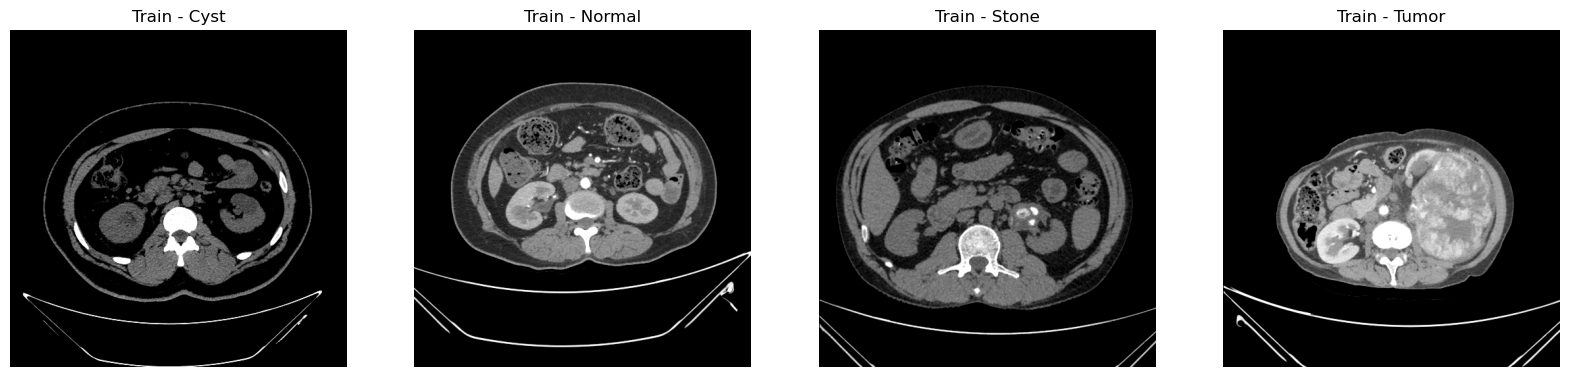

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt


def visualize_samples(directory, subset='train'):
    fig, axes = plt.subplots(nrows=1, ncols=len(classes), figsize=(20, 5))
    

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, subset, class_name)
        img_list = os.listdir(class_dir)
        img_name = random.choice(img_list)
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{subset.capitalize()} - {class_name}')
        axes[i].axis('off')

    plt.show()

visualize_samples(base_dir, 'train')


In [ ]:
def preprocess_image(image):

    # resizing and normalizing images
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image

def preprocess_sequence(image_paths):
    
    # loading and preprocessing 
    images = [preprocess_image(tf.image.decode_jpeg(tf.io.read_file(img))) for img in image_paths]
    return tf.stack(images, axis=0)  # Stack into a single tensor for 3D CNN or CNN-LSTM


In [35]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])


In [ ]:
# initializing train generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=42  
)

# setting class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# validation and test data generators
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
validation_generator = validation_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    seed=42  
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    seed=42 
)


Found 9954 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, GlobalAveragePooling3D
from tensorflow.keras import Input, Model


# 3 frames in every sequence
sequence_length = 3  

# input specifications
inputs = Input(shape=(sequence_length, IMG_HEIGHT, IMG_WIDTH, 1))

# 3D Convolutional layers 
x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)  # Only downsample spatial dimensions
x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)
x = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)

# Global pooling for all features
x = GlobalAveragePooling3D()(x)

# Fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
outputs = Dense(len(classes), activation='softmax')(x)

# complie the model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 224, 224, 1)]  0         
                                                                 
 conv3d_3 (Conv3D)           (None, 3, 224, 224, 32)   896       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 112, 112, 32)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 112, 112, 64)   55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 56, 56, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 3, 56, 56, 128)    2213

In [38]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (tf.ones_like(y_pred) - y_pred)
        return -tf.reduce_mean(alpha_t * tf.math.pow((tf.ones_like(y_true) - p_t), gamma) * tf.math.log(p_t))
    return focal_loss_fixed

model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])


In [39]:
EPOCHS = 20
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)


Epoch 1/20
312/312 [==============================] - 156s 495ms/step - loss: 0.0477 - accuracy: 0.5654 - val_loss: 0.0432 - val_accuracy: 0.6340
Epoch 2/20
312/312 [==============================] - 145s 465ms/step - loss: 0.0399 - accuracy: 0.6731 - val_loss: 0.0386 - val_accuracy: 0.6926
Epoch 3/20
312/312 [==============================] - 145s 465ms/step - loss: 0.0374 - accuracy: 0.6988 - val_loss: 0.0366 - val_accuracy: 0.6950
Epoch 4/20
312/312 [==============================] - 145s 466ms/step - loss: 0.0358 - accuracy: 0.7087 - val_loss: 0.0349 - val_accuracy: 0.7231
Epoch 5/20
312/312 [==============================] - 145s 465ms/step - loss: 0.0323 - accuracy: 0.7349 - val_loss: 0.0293 - val_accuracy: 0.7689
Epoch 6/20
312/312 [==============================] - 144s 462ms/step - loss: 0.0298 - accuracy: 0.7587 - val_loss: 0.0271 - val_accuracy: 0.7793
Epoch 7/20
312/312 [==============================] - 145s 464ms/step - loss: 0.0261 - accuracy: 0.7918 - val_loss: 0.0240 -

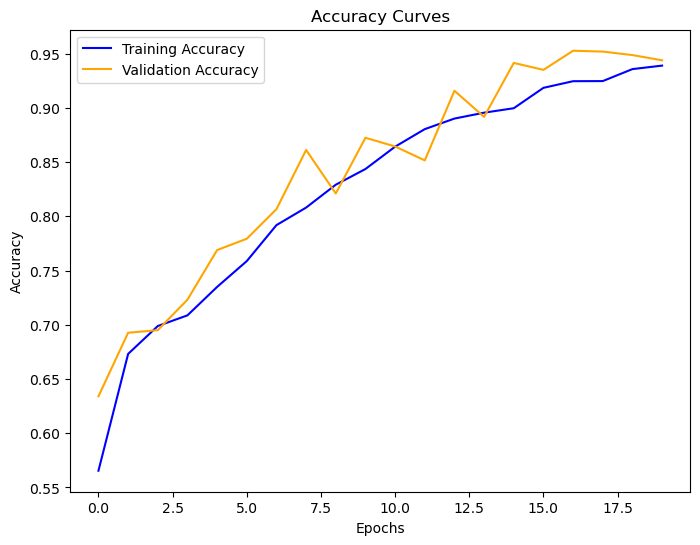

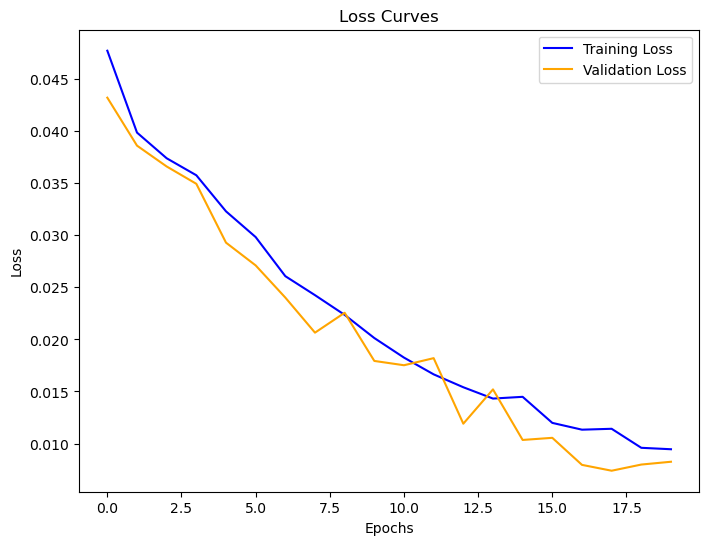

In [ ]:
# Function to plot training history
def plot_training_history(history):

    # accuracy curves val v/s train
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # loss curves val v/s train
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# calling the function to plot training history
plot_training_history(history)


39/39 [==============================] - 8s 215ms/step


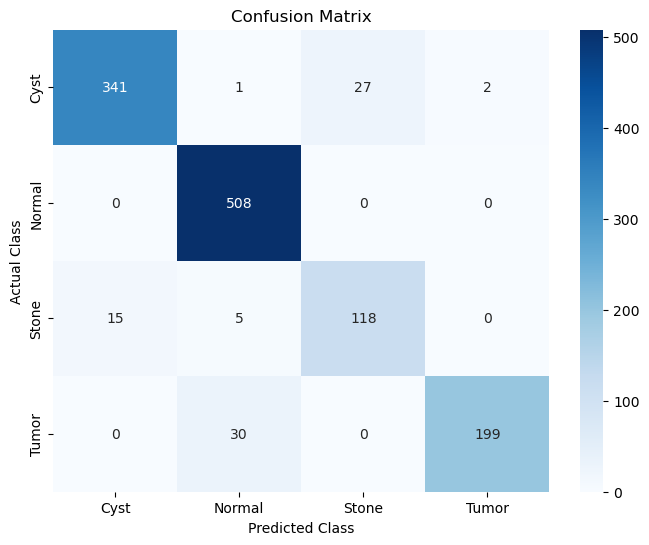

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.96      0.92      0.94       371
      Normal       0.93      1.00      0.97       508
       Stone       0.81      0.86      0.83       138
       Tumor       0.99      0.87      0.93       229

    accuracy                           0.94      1246
   macro avg       0.92      0.91      0.92      1246
weighted avg       0.94      0.94      0.94      1246



In [ ]:
# Evaluate the model on the test data
def evaluate_model(model, test_generator):

    # prediction with test data
    test_steps = test_generator.samples // test_generator.batch_size + 1
    predictions = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    #  confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

  
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

    # classification report
    report = classification_report(y_true, y_pred, target_names=classes)
    print('Classification Report:')
    print(report)

# calling the function
evaluate_model(model, test_generator)


In [ ]:
# fine tuning class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# initial weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

#  Stone and Tumor classes having lesser images set with higher learning rates

# Increase weight for Stone by 20%
class_weights_dict[2] *= 1.2
# increasing weight for Tumor by 10%  
class_weights_dict[3] *= 1.1  

print("Adjusted class weights for fine-tuning:", class_weights_dict)

# fine tuning the model using custom weights for classes
fine_tune_epochs = 10  
history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=fine_tune_epochs,
    class_weight=class_weights_dict 
)


Adjusted class weights for fine-tuning: {0: 0.8387259858442871, 1: 0.6127801034228023, 2: 2.712261580381471, 3: 1.4999178082191782}
Epoch 1/10
312/312 [==============================] - 144s 462ms/step - loss: 0.0083 - accuracy: 0.9474 - val_loss: 0.0061 - val_accuracy: 0.9615
Epoch 2/10
312/312 [==============================] - 144s 462ms/step - loss: 0.0102 - accuracy: 0.9408 - val_loss: 0.0086 - val_accuracy: 0.9502
Epoch 3/10
312/312 [==============================] - 144s 462ms/step - loss: 0.0111 - accuracy: 0.9356 - val_loss: 0.0082 - val_accuracy: 0.9510
Epoch 4/10
312/312 [==============================] - 144s 461ms/step - loss: 0.0072 - accuracy: 0.9579 - val_loss: 0.0058 - val_accuracy: 0.9631
Epoch 5/10
312/312 [==============================] - 144s 461ms/step - loss: 0.0066 - accuracy: 0.9629 - val_loss: 0.0073 - val_accuracy: 0.9478
Epoch 6/10
312/312 [==============================] - 145s 464ms/step - loss: 0.0075 - accuracy: 0.9567 - val_loss: 0.0045 - val_accuracy:

39/39 [==============================] - 8s 210ms/step


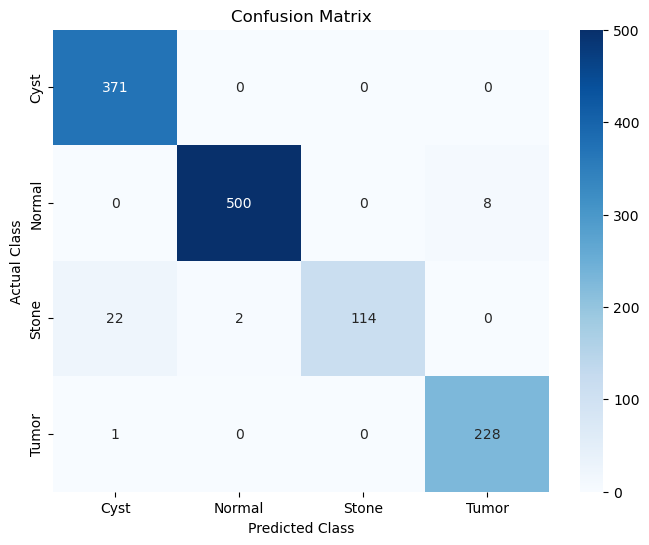

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.94      1.00      0.97       371
      Normal       1.00      0.98      0.99       508
       Stone       1.00      0.83      0.90       138
       Tumor       0.97      1.00      0.98       229

    accuracy                           0.97      1246
   macro avg       0.98      0.95      0.96      1246
weighted avg       0.97      0.97      0.97      1246



In [ ]:
# re evaluation of performance after fine -tuning -1
evaluate_model(model, test_generator)


In [ ]:
# fine tuning class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# initial weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

#  Stone and Tumor classes having lesser images set with higher learning rates

# Increase weight for Stone by 10%
class_weights_dict[2] *= 1.1
# increasing weight for Tumor by 10%  
class_weights_dict[3] *= 1.1  

print("Adjusted class weights for fine-tuning:", class_weights_dict)

# fine tuning the model using custom weights for classes
fine_tune_epochs = 10  
history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=fine_tune_epochs,
    class_weight=class_weights_dict 
)


Adjusted class weights for fine-tuning: {0: 0.8387259858442871, 1: 0.6127801034228023, 2: 2.486239782016349, 3: 1.4999178082191782}
Epoch 1/10
312/312 [==============================] - 144s 461ms/step - loss: 0.0039 - accuracy: 0.9773 - val_loss: 0.0022 - val_accuracy: 0.9896
Epoch 2/10
312/312 [==============================] - 144s 460ms/step - loss: 0.0048 - accuracy: 0.9730 - val_loss: 0.0018 - val_accuracy: 0.9920
Epoch 3/10
312/312 [==============================] - 144s 461ms/step - loss: 0.0054 - accuracy: 0.9714 - val_loss: 0.0031 - val_accuracy: 0.9791
Epoch 4/10
312/312 [==============================] - 144s 462ms/step - loss: 0.0042 - accuracy: 0.9780 - val_loss: 0.0023 - val_accuracy: 0.9928
Epoch 5/10
312/312 [==============================] - 144s 460ms/step - loss: 0.0031 - accuracy: 0.9848 - val_loss: 0.0015 - val_accuracy: 0.9928
Epoch 6/10
312/312 [==============================] - 144s 460ms/step - loss: 0.0030 - accuracy: 0.9836 - val_loss: 0.0018 - val_accuracy:

39/39 [==============================] - 8s 210ms/step


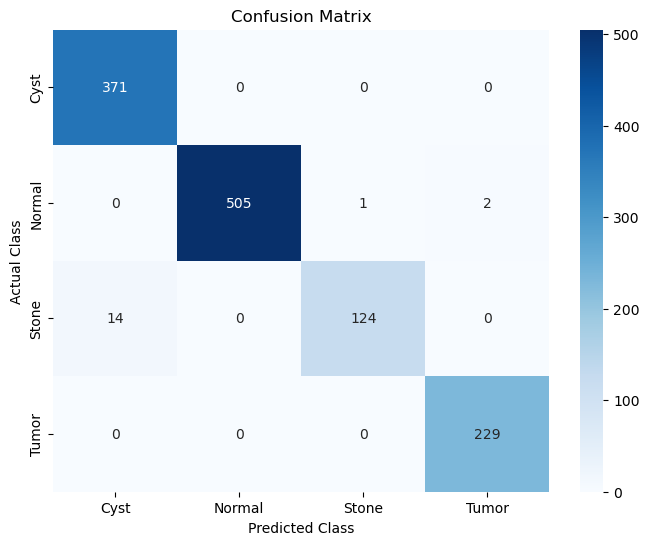

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.96      1.00      0.98       371
      Normal       1.00      0.99      1.00       508
       Stone       0.99      0.90      0.94       138
       Tumor       0.99      1.00      1.00       229

    accuracy                           0.99      1246
   macro avg       0.99      0.97      0.98      1246
weighted avg       0.99      0.99      0.99      1246



In [ ]:
# re evaluate
evaluate_model(model, test_generator)


In [ ]:
# fine tuning class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# initial weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

#  Stone and Tumor classes having lesser images set with higher learning rates

# Increase weight for Stone by 20%
class_weights_dict[2] *= 1.2
# increasing weight for Tumor by 7%  
class_weights_dict[3] *= 1.07  

print("Adjusted class weights for fine-tuning:", class_weights_dict)

# fine tuning the model using custom weights for classes
fine_tune_epochs = 10  
history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=fine_tune_epochs,
    class_weight=class_weights_dict 
)


Adjusted class weights for fine-tuning: {0: 0.8387259858442871, 1: 0.6127801034228023, 2: 2.486239782016349, 3: 1.4590109589041096}
Epoch 1/10
312/312 [==============================] - 144s 462ms/step - loss: 0.0026 - accuracy: 0.9880 - val_loss: 0.0082 - val_accuracy: 0.9518
Epoch 2/10
312/312 [==============================] - 144s 461ms/step - loss: 0.0023 - accuracy: 0.9901 - val_loss: 4.4507e-04 - val_accuracy: 0.9992
Epoch 3/10
312/312 [==============================] - 144s 461ms/step - loss: 0.0010 - accuracy: 0.9954 - val_loss: 8.7981e-04 - val_accuracy: 0.9944
Epoch 4/10
312/312 [==============================] - 144s 461ms/step - loss: 0.0018 - accuracy: 0.9917 - val_loss: 4.1095e-04 - val_accuracy: 1.0000
Epoch 5/10
312/312 [==============================] - 144s 462ms/step - loss: 0.0038 - accuracy: 0.9839 - val_loss: 0.0012 - val_accuracy: 0.9928
Epoch 6/10
312/312 [==============================] - 144s 461ms/step - loss: 0.0011 - accuracy: 0.9957 - val_loss: 8.0322e-04

39/39 [==============================] - 8s 215ms/step


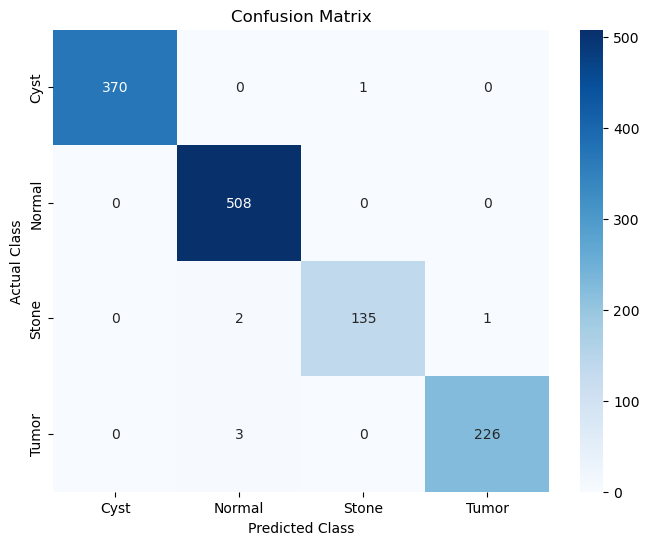

Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       371
      Normal       0.99      1.00      1.00       508
       Stone       0.99      0.98      0.99       138
       Tumor       1.00      0.99      0.99       229

    accuracy                           0.99      1246
   macro avg       0.99      0.99      0.99      1246
weighted avg       0.99      0.99      0.99      1246



In [ ]:
# re-evaluating
evaluate_model(model, test_generator)


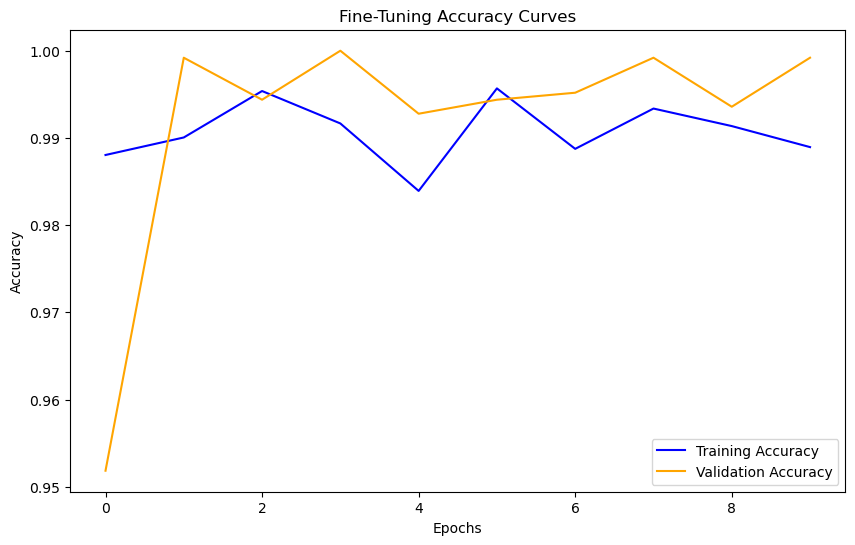

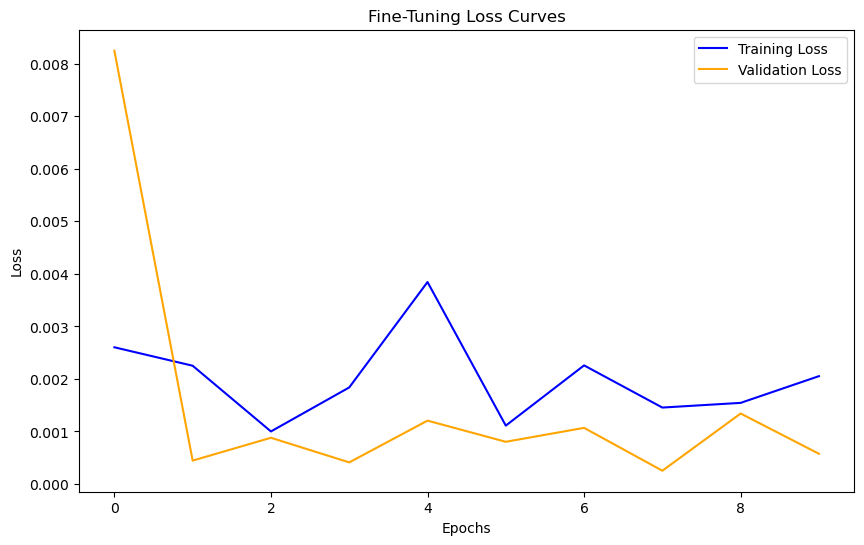

In [50]:
# Function to plot only fine-tuning accuracy and loss curves
def plot_fine_tuning_history(fine_tune_history):
    # Accuracy and loss from fine-tuning only
    acc = fine_tune_history.history['accuracy']
    val_acc = fine_tune_history.history['val_accuracy']
    loss = fine_tune_history.history['loss']
    val_loss = fine_tune_history.history['val_loss']
    
    # Plot accuracy curves
    plt.figure(figsize=(10, 6))
    plt.plot(acc, label='Training Accuracy', color='blue')
    plt.plot(val_acc, label='Validation Accuracy', color='orange')
    plt.title('Fine-Tuning Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title('Fine-Tuning Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function with only the fine-tuning history
plot_fine_tuning_history(history_fine_tune)
